In [9]:
import sys
import os
from sam2 import sam2_image_predictor
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch
import math
import io
import base64
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [10]:
def add_grid_to_image(image_path, show_image=True):
    # Open the image
    img = Image.open(image_path)

    # Get image dimensions
    img_width, img_height = img.size

    # Calculate number of grid lines
    num_lines_x = math.ceil(img_width / 50)
    num_lines_y = math.ceil(img_height / 50)

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(15, 15))

    # Display the image
    ax.imshow(img)

    # Set up the grid
    ax.set_xticks(np.arange(0, img_width, 50))
    ax.set_yticks(np.arange(0, img_height, 50))

    # Add gridlines
    ax.grid(color='blue', linestyle=(0, (5, 10)), linewidth=1)

    # Set axis labels
    ax.set_xlabel('X-axis (pixels)')
    ax.set_ylabel('Y-axis (pixels)')

    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')

    # Add numerical labels
    ax.set_xticks(np.linspace(0, img_width, num_lines_x + 1))
    ax.set_yticks(np.linspace(0, img_height, num_lines_y + 1))

    plt.title('Image with Labeled Grid Overlay')
    plt.tight_layout()

    # Save the figure to a BytesIO object

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    # Convert the BytesIO object to base64
    base64_str = base64.b64encode(buf.getvalue()).decode('utf-8')

    # Close the figure to free up memory

    return base64_str

In [15]:
def show_masks_with_grid(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True, grid_spacing=50):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        # Create a new figure and axis
        fig, ax = plt.subplots(figsize=(15, 15))

        # Display the image
        ax.imshow(image)

        # Show the mask
        show_mask(mask, ax, borders=borders)

        # Get image dimensions
        img_height, img_width = image.shape[:2]

        # Calculate number of grid lines
        num_lines_x = math.ceil(img_width / grid_spacing)
        num_lines_y = math.ceil(img_height / grid_spacing)

        # Set up the grid
        ax.set_xticks(np.arange(0, img_width, grid_spacing))
        ax.set_yticks(np.arange(0, img_height, grid_spacing))

        # Add gridlines
        ax.grid(color='blue', linestyle=(0, (5, 10)), linewidth=1)

        # Set axis labels
        ax.set_xlabel('X-axis (pixels)')
        ax.set_ylabel('Y-axis (pixels)')

        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=90, ha='center')

        # Add numerical labels
        ax.set_xticks(np.linspace(0, img_width, num_lines_x + 1))
        ax.set_yticks(np.linspace(0, img_height, num_lines_y + 1))

        # if point_coords is not None:
        #     assert input_labels is not None
        #     show_points(point_coords, input_labels, ax)

        # if box_coords is not None:
        #     show_box(box_coords, ax)

        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        else:
            plt.title("Mask with Grid Overlay", fontsize=18)

        plt.tight_layout()
        plt.show()

    # Return the last figure as a base64 encoded string
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    base64_str = base64.b64encode(buf.getvalue()).decode('utf-8')
    plt.close()  # Close the figure to free up memory

    return base64_str

In [5]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

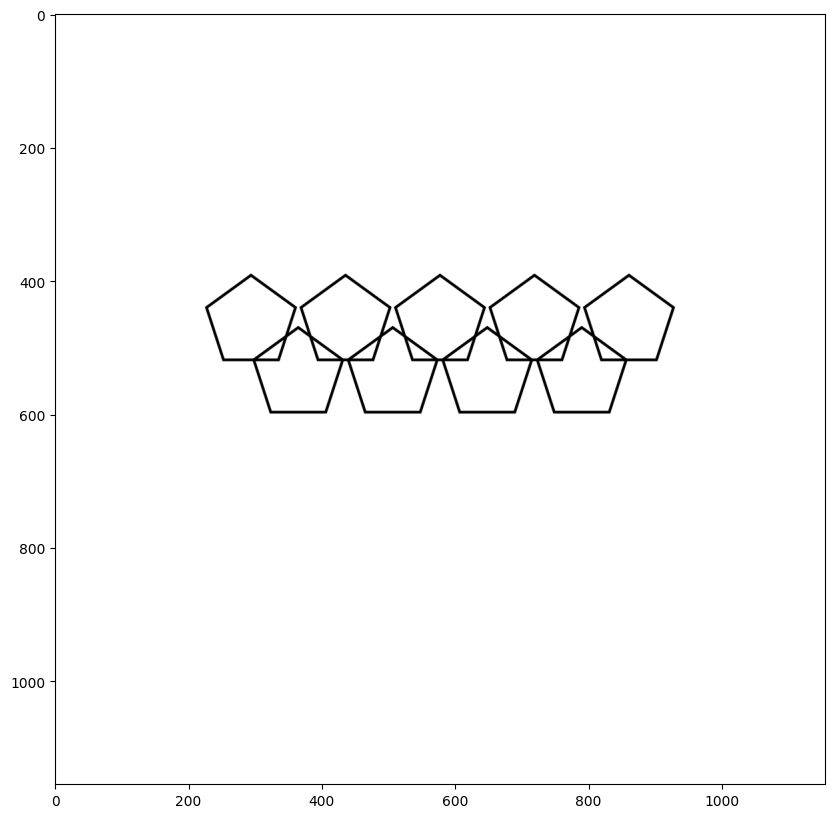

In [7]:
image = Image.open('images/lottapentagon.png')
image = np.array(image.convert("RGB"))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sam2_checkpoint = "../checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

device = torch.device("cpu")
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(image)

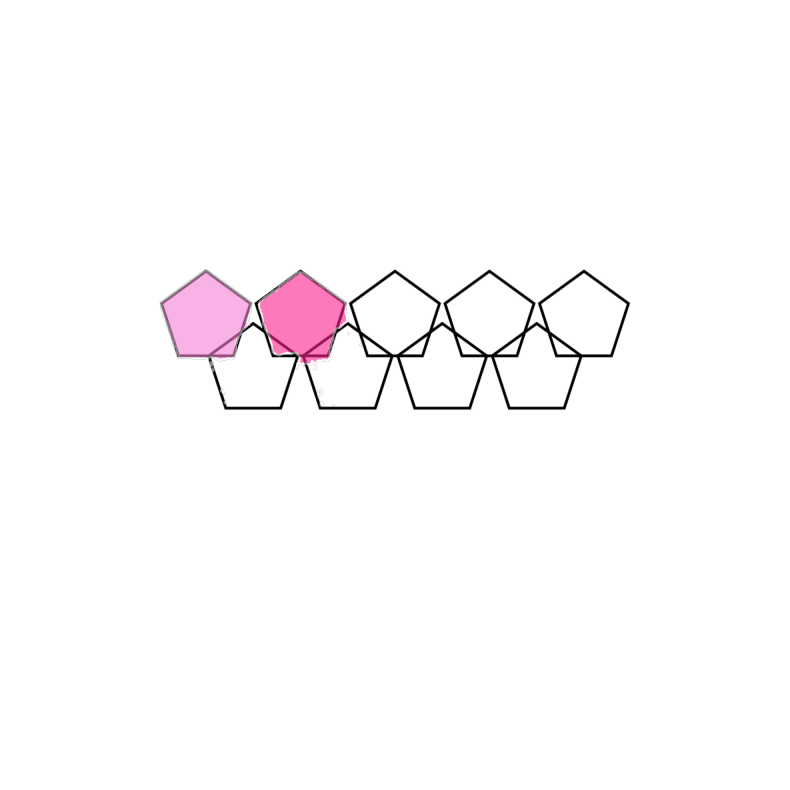

In [31]:
input_boxes = np.array([240, 385, 385, 578])
box2 = np.array([385, 385, 530, 580])

input_boxes = np.vstack((input_boxes, box2))

input_point = np.array([[100, 100]])
input_label = np.array([0])

# mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
# masks, scores, logits = predictor.predict(
#     point_coords=input_point,
#     point_labels=input_label,
#     box=input_box,
#     multimask_output=False,
# )
# show_masks(image, masks, scores, box_coords=input_box, point_coords=input_point, input_labels=input_label)

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
# for box in input_boxes:
#     show_box(box, plt.gca())
plt.axis('off')
plt.show()
